# APPENDIX B: Testing spherical symmetry and isotropy

In [2]:
import sys
import pickle
from numpy import *

import treal_functions
import slopes_functions
import prepare_functions
import cuspcore_aux
import cuspcore_plots
import evolving
import fitting as fit
from cuspcore_aux import *
from cuspcore_plots import *
from evolving import *

sim = ['g1.08e11'][0]
directory='/cs/sci/freundlich/CUSPCORE/NIHAO_data/' 

with open(directory+'NIHAO-%s.pickle'%sim[1:]) as f:
    gl = pickle.load(f)
 
gl = slopes_functions.derive_slopes(gl,polyorder=3,sigma = 21,mode= 'interp',double_smooth=False,rlim=[-2.,0.],use_fangzhou_Rvir=True)    
gl = prepare_functions.define_brho(gl,polyorder=3,sigma = 21,mode= 'interp',double_smooth=False,rlim=[-2.,0.],use_fangzhou_Rvir=True)
treal=treal_functions.load_or_create_gl(sim)

fitrange=prepare_functions.get_fitrange(gl)
gl=prepare_functions.reduce_range_gl(gl,fitrange)
treal=prepare_functions.reduce_range_Treal(treal,fitrange)


a_array=[]

for (i,ss) in zip(range(size(gl)),gl):
    a_array.append(ss['a'])           

a_array=array(a_array)

ok_fangzhou,r12_fangzhou,rvir_fangzhou,mvir_fangzhou=get_fangzhou_radii(sim,a_array,get_all=False)
gl=fit.do_fits(gl,rvir_fangzhou,mvir_fangzhou,1.,0.01,2.,components=['d'])

print 'Done'

 
Loading existing file Treal-1.08e11.pickle
Reducing the range of gl
Reducing the range of Treal
Done


In [11]:
# FIGURE PROPERTIES

fontsize=20
legendsize=fontsize
linewidth=2
linesize=5
ticksize=fontsize-4
figsize=(8,16)
figsize=(8,12)

rcParams['axes.linewidth'] = 1
rcParams['xtick.major.size'] = 6
rcParams['xtick.major.width'] = 1
rcParams['xtick.minor.size'] = 3
rcParams['xtick.minor.width'] = 1
rcParams['ytick.major.size'] = 6
rcParams['ytick.major.width'] = 1
rcParams['ytick.minor.size'] = 3
rcParams['ytick.minor.width'] = 1
rcParams['xtick.labelsize'] = fontsize
rcParams['ytick.labelsize'] = fontsize

rcParams['figure.subplot.left']=0.15
rcParams['figure.subplot.right']=0.95
rcParams['figure.subplot.bottom']=0.15
rcParams['figure.subplot.top']=0.95
rcParams['figure.subplot.wspace']=0.1
rcParams['figure.subplot.hspace']=0.1


In [4]:
# COMPARE Kreal and Kvirial

from matplotlib.pylab import *
G = 4.499753324353496e-06 # gravitational constant [kpc^3 Gyr^-2 Msun^-1]

rlim=array([-2.,0.])
component='d'
tmin=2.

parsec=3.085677581e16 #m
year=3.1557600e7 #s
kms_to_kpcGyr=1/parsec*year*1e9


/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


mean difference:  -0.0311706984452
mean RMS difference:  0.0418489998075


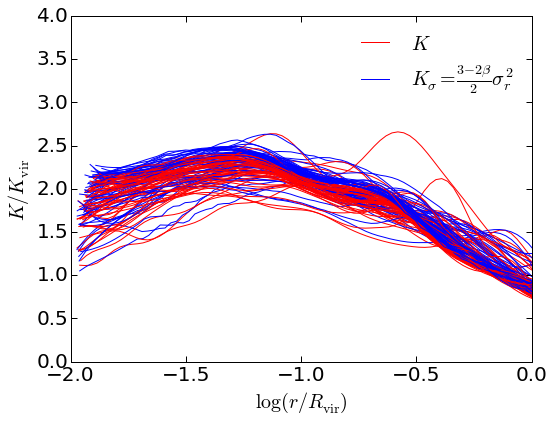

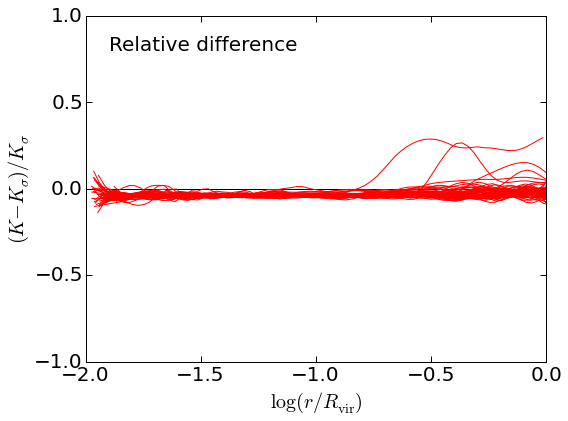

In [5]:
figure(figsize=(8,6))
axhline(0,color='gray')
counter=0
for (ss, i) in zip(gl, range(size(gl))):
    
    r= ss[component]['r']
    Rvir=ss['Rvir']
    Mvir=ss[component]['Mvir']
    Kvir=0.5*G*Mvir/Rvir
    logr=log10(ss[component]['r']/ss['Rvir'])
    t=ss['t']
    
    # Tsigma = (3-2beta)/2 sigma_r^2
    sigma2=(ss[component]['sigmar_smooth']/3.085677581*3.1556952)**2
    Tsigma=(3.-2.*ss[component]['beta_smooth'])/2.*sigma2/Kvir
        
    # T real
    T_real=treal[i][2]/Kvir
    
    if t>tmin:
        if counter==0:
            plot(logr,T_real,color='r',label=r'$K$')
            plot(logr,Tsigma,color='b',linestyle='-',label=r'$K_{\sigma}=\frac{3-2\beta}{2}\sigma_r^2$')
        else:
            plot(logr,T_real,color='r')
            plot(logr,Tsigma,color='b',linestyle='-')
            
            
        counter=counter+1
        
xlabel(r'$\log(r/R_{\rm vir})$',fontsize=fontsize)
ylabel(r'$K/K_{\rm vir}$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$
legend(fontsize=legendsize,frameon=False,loc='upper right')

ylim(0,4)
xlim(rlim)

###############################

figure(figsize=(8,6))
axhline(0,color='k')
DT_all=[]
DT_mean=[]
DT_rms=[]

for (ss, i) in zip(gl, range(size(gl))):
    
    r= ss[component]['r']
    Rvir=ss['Rvir']
    Mvir=ss[component]['Mvir']
    Kvir=0.5*G*Mvir/Rvir
    logr=log10(ss[component]['r']/ss['Rvir'])
    t=ss['t']
    
    # Tsigma = (3-2beta)/2 sigma_r^2
    sigma2=(ss[component]['sigmar_smooth']/3.085677581*3.1556952)**2
    Tsigma=(3.-2.*ss[component]['beta_smooth'])/2.*sigma2/Kvir

    # T real
    T_real=treal[i][2]/Kvir
    
    # Relative difference
    DT=(T_real-Tsigma)/Tsigma
    
    if t>tmin:
        rrange=where((logr>rlim[0])&(logr<rlim[1]))
        DT_all.append(array(DT[rrange]))
        DT_mean.append(mean(array_nonan(array(DT[rrange]))))
        DT_rms.append(sqrt(mean(array_nonan(array(DT[rrange])**2))))

        plot(logr,DT,color='r',linestyle='-')
        
xlabel(r'$\log(r/R_{\rm vir})$',fontsize=fontsize)
ylabel(r'$(K-K_{\sigma})/K_\sigma$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$

legend(fontsize=legendsize,frameon=False,loc='upper left')

ylim(-1.,1)
xlim(rlim)
ax=gca()
ax.text(0.05,0.9,r'Relative difference',fontsize=fontsize,transform=ax.transAxes)

print 'mean difference: ', mean(array_nonan(array(DT_mean)))
print 'mean RMS difference: ', mean(array_nonan(array(DT_rms)))
    

In [21]:
abscisse=log10(logspace(-2,0,1000))

K_curve=[]
Ksigma_curve=[]
Ksigma0_curve=[]
DK_curve=[]
DK0_curve=[]

for (ss, i) in zip(gl, range(size(gl))):
    
    r= ss[component]['r']
    Rvir=ss['Rvir']
    Mvir=ss[component]['Mvir']
    Kvir=0.5*G*Mvir/Rvir
    logr=log10(ss[component]['r']/ss['Rvir'])
    t=ss['t']

    # Tsigma = (3-2beta)/2 sigma_r^2
    sigma2=(ss[component]['sigmar_smooth']/3.085677581*3.1556952)**2
    Tsigma=(3.-2.*ss[component]['beta_smooth'])/2.*sigma2/Kvir
    Tsigma0=3/2.*sigma2/Kvir

    # T real
    T_real=treal[i][2]/Kvir

    #Relative difference
    DT=(T_real-Tsigma)/Tsigma
    DT0=(T_real-Tsigma0)/Tsigma0
    rrange=where((logr<rlim[0])&(logr>rlim[1]))
    DT[rrange]=nan
    DT0[rrange]=nan
    
    if t>tmin:
        K_curve.append(list(interp(abscisse,logr,T_real,left=nan,right=nan)))
        Ksigma_curve.append(list(interp(abscisse,logr,Tsigma,left=nan,right=nan)))
        DK_curve.append(list(interp(abscisse,logr,DT,left=nan,right=nan)))
        Ksigma0_curve.append(list(interp(abscisse,logr,Tsigma0,left=nan,right=nan)))
        DK0_curve.append(list(interp(abscisse,logr,DT0,left=nan,right=nan)))

K_curve=array(K_curve)
Ksigma_curve=array(Ksigma_curve)
DK_curve=array(DK_curve)
Ksigma0_curve=array(Ksigma0_curve)
DK0_curve=array(DK0_curve)

K_min=nan*ones_like(abscisse)
K_max=nan*ones_like(abscisse)
K_med=nan*ones_like(abscisse)
Ksigma_min=nan*ones_like(abscisse)
Ksigma_max=nan*ones_like(abscisse)
Ksigma_med=nan*ones_like(abscisse)
Ksigma0_min=nan*ones_like(abscisse)
Ksigma0_max=nan*ones_like(abscisse)
Ksigma0_med=nan*ones_like(abscisse)
DK_min=nan*ones_like(abscisse)
DK_max=nan*ones_like(abscisse)
DK_med=nan*ones_like(abscisse)
DK_rms=nan*ones_like(abscisse)
DK0_min=nan*ones_like(abscisse)
DK0_max=nan*ones_like(abscisse)
DK0_med=nan*ones_like(abscisse)
DK0_rms=nan*ones_like(abscisse)
for i in range(size(abscisse)):
    try:
        K_min[i]=amin(array_nonan(K_curve[:,i]))
        K_max[i]=amax(array_nonan(K_curve[:,i]))
        K_med[i]=median((K_curve[:,i]))
    except:
        continue
    try:
        Ksigma_min[i]=amin(array_nonan(Ksigma_curve[:,i]))
        Ksigma_max[i]=amax(array_nonan(Ksigma_curve[:,i]))
        Ksigma_med[i]=median((Ksigma_curve[:,i]))
    except:
        continue    
    try:
        DK_min[i]=amin(array_nonan(DK_curve[:,i]))
        DK_max[i]=amax(array_nonan(DK_curve[:,i]))
        DK_med[i]=median((DK_curve[:,i]))
        DK_rms[i]=std(array_nonan(DK_curve[:,i]))
    except:
        continue        
    try:
        Ksigma0_min[i]=amin(array_nonan(Ksigma0_curve[:,i]))
        Ksigma0_max[i]=amax(array_nonan(Ksigma0_curve[:,i]))
        Ksigma0_med[i]=median((Ksigma0_curve[:,i]))
    except:
        continue    
    try:
        DK0_min[i]=amin(array_nonan(DK0_curve[:,i]))
        DK0_max[i]=amax(array_nonan(DK0_curve[:,i]))
        DK0_med[i]=median((DK0_curve[:,i]))
        DK0_rms[i]=std(array_nonan(DK0_curve[:,i]))
    except:
        continue        


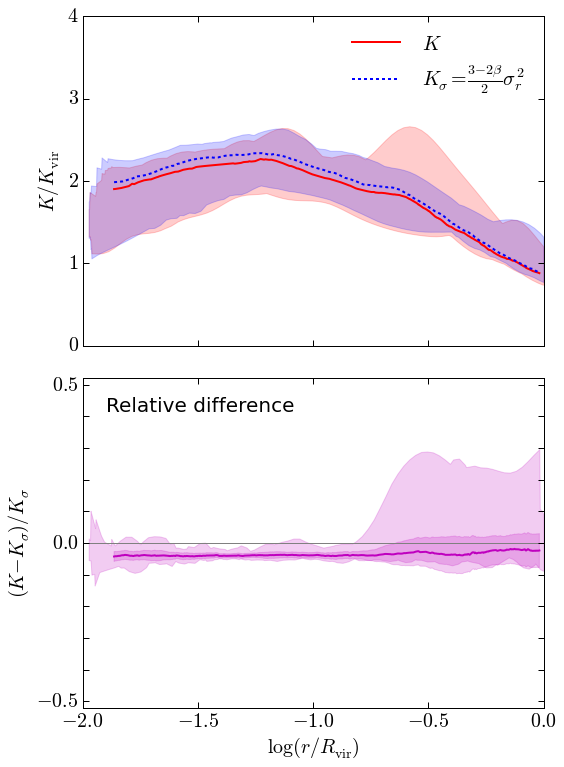

In [19]:
alpha_fill=0.2


fig=figure(figsize=figsize)
clf()

ax3=subplot(211)

fill_between(abscisse,K_min,K_max,color='r',alpha=alpha_fill)
plot(abscisse,K_med,color='r',lw=2,label=r'$K$')

fill_between(abscisse,Ksigma_min,Ksigma_max,color='b',alpha=alpha_fill)
plot(abscisse,Ksigma_med,color='b',ls='--',dashes=(3,3),lw=2,label=r'$K_{\sigma}=\frac{3-2\beta}{2}\sigma_r^2$')

ylabel(r'$K/K_{\rm vir}$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$
legend(fontsize=legendsize,frameon=False,loc='upper right',handlelength=3)

#yscale('log')
ax3.invert_yaxis()
yticknames=['$%i$'%int(item) for item in linspace(0,4,5)]
yticks(linspace(0,4,5),yticknames)

xticknames=['$%.1f$'%log10(item) for item in logspace(-2,1,7)]
xticks(log10(logspace(-2,1,7)),xticknames)

ylim(0,4)
xlim(rlim)

ax2=subplot(212, sharex=ax3)

axhline(0,color='gray')

fill_between(abscisse,DK_min,DK_max,color='m',alpha=alpha_fill)
fill_between(abscisse,DK_med-DK_rms,DK_med+DK_rms,color='m',alpha=alpha_fill)
plot(abscisse,DK_med,lw=2,color='m')

xlabel(r'$\log(r/R_{\rm vir})$',fontsize=fontsize)
ylabel(r'$(K-K_{\sigma})/K_\sigma$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$

xticknames=['$%.1f$'%log10(item) for item in logspace(-2,0,5)]
xticks(log10(logspace(-2,0,5)),xticknames,visible=True)

yticknames=['$%.1f$'%log10(item) for item in logspace(-0.5,0.5,11)]
yticknames=['$-0.5$', ' ', ' ', ' ', ' ', '$0.0$', ' ', ' ', ' ', ' ','$0.5$']
yticks(log10(logspace(-0.5,0.5,11)),yticknames,visible=True)

ylim(-.52,.52)
xlim(rlim)

ax=gca()
ax.text(0.05,0.9,r'Relative difference',fontsize=fontsize,transform=ax.transAxes)

setp(ax3.get_xticklabels(), visible=False)

savefig('/vol/sci/astro/home/freundlich/CUSPCORE/ARTICLE/figures2/fig_kinetic_Ksigma.pdf')#, bbox_inches='tight')


mean difference:  -0.0916288148364
mean RMS difference:  0.105550351448


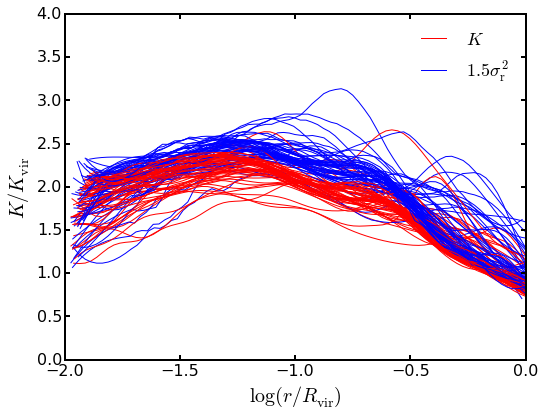

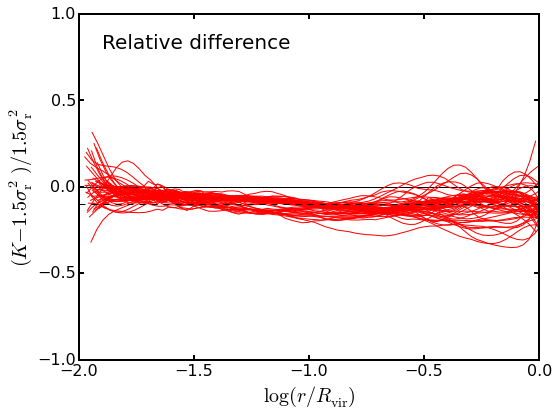

In [24]:
# COMPARE Kreal and Ksigma = (3-2beta)/2 sigma_r^2

from matplotlib.pylab import *
G = 4.499753324353496e-06 # gravitational constant [kpc^3 Gyr^-2 Msun^-1]

fontsize=20
legendsize=18
linewidth=2
linesize=5

rcParams['axes.linewidth'] = linewidth
rcParams['xtick.major.size'] = linesize
rcParams['xtick.major.width'] = linewidth
rcParams['xtick.minor.size'] = linesize
rcParams['xtick.minor.width'] = linewidth
rcParams['ytick.major.size'] = linesize
rcParams['ytick.major.width'] = linewidth
rcParams['ytick.minor.size'] = linesize
rcParams['ytick.minor.width'] = linewidth
rcParams['xtick.labelsize'] = fontsize-4
rcParams['ytick.labelsize'] = fontsize-4

rlim=[-2.,0.]
component='d'
tmin=2.

parsec=3.085677581e16 #m
year=3.1557600e7 #s
kms_to_kpcGyr=1/parsec*year*1e9

###############################

figure(figsize=(8,6))
axhline(0,color='gray')
counter=0
for (ss, i) in zip(gl, range(size(gl))):
    
    r= ss[component]['r']
    Rvir=ss['Rvir']
    Mvir=ss[component]['Mvir']
    Kvir=0.5*G*Mvir/Rvir
    logr=log10(ss[component]['r']/ss['Rvir'])
    t=ss['t']
    
    # Tsigma = (3-2beta)/2 sigma_r^2
    sigma2=(ss[component]['sigmar_smooth']/3.085677581*3.1556952)**2
    Tsigma=3/2.*sigma2/Kvir
    #Tsigma_smooth=savgol_filter(Tr, sigma, 2, deriv=0, delta=diff(logr)[0])
        
    # T real
    T_real=treal[i][2]/Kvir
    
    if t>tmin:
        if counter==0:
            plot(logr,T_real,color='r',label=r'$K$')
            plot(logr,Tsigma,color='b',linestyle='-',label=r'$1.5\sigma_{\rm r}^2$')
        else:
            plot(logr,T_real,color='r')
            plot(logr,Tsigma,color='b',linestyle='-')
            
        counter=counter+1
        
xlabel(r'$\log(r/R_{\rm vir})$',fontsize=fontsize)
ylabel(r'$K/K_{\rm vir}$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$
legend(fontsize=legendsize,frameon=False,loc='upper right')

ylim(0,4)
xlim(rlim)

###############################

figure(figsize=(8,6))
axhline(0,color='k')
DT_all=[]
DT_mean=[]
DT_rms=[]

for (ss, i) in zip(gl, range(size(gl))):
    
    r= ss[component]['r']
    Rvir=ss['Rvir']
    Mvir=ss[component]['Mvir']
    Kvir=0.5*G*Mvir/Rvir
    logr=log10(ss[component]['r']/ss['Rvir'])
    t=ss['t']
    
    # Tsigma = (3-2beta)/2 sigma_r^2
    sigma2=(ss[component]['sigmar_smooth']/3.085677581*3.1556952)**2
    Tsigma=3/2.*sigma2/Kvir

    # T real
    T_real=treal[i][2]/Kvir
    
    # Relative difference
    DT=(T_real-Tsigma)/Tsigma
    
    if t>tmin:
        rrange=where((logr>rlim[0])&(logr<rlim[1]))
        DT_all.append(array(DT[rrange]))
        DT_mean.append(mean(array_nonan(array(DT[rrange]))))
        DT_rms.append(sqrt(mean(array_nonan(array(DT[rrange])**2))))

        plot(logr,DT,color='r',linestyle='-')
        
xlabel(r'$\log(r/R_{\rm vir})$',fontsize=fontsize)
ylabel(r'$(K-1.5 \sigma_{\rm r}^2)/1.5\sigma_{\rm r}^2$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$


legend(fontsize=legendsize,frameon=False,loc='upper left')

ylim(-1.,1)
xlim(rlim)
ax=gca()
ax.text(0.05,0.9,r'Relative difference',fontsize=fontsize,transform=ax.transAxes)

axhline(-0.1,color='k',linestyle='--')

print 'mean difference: ', mean(array_nonan(array(DT_mean)))
print 'mean RMS difference: ', mean(array_nonan(array(DT_rms)))

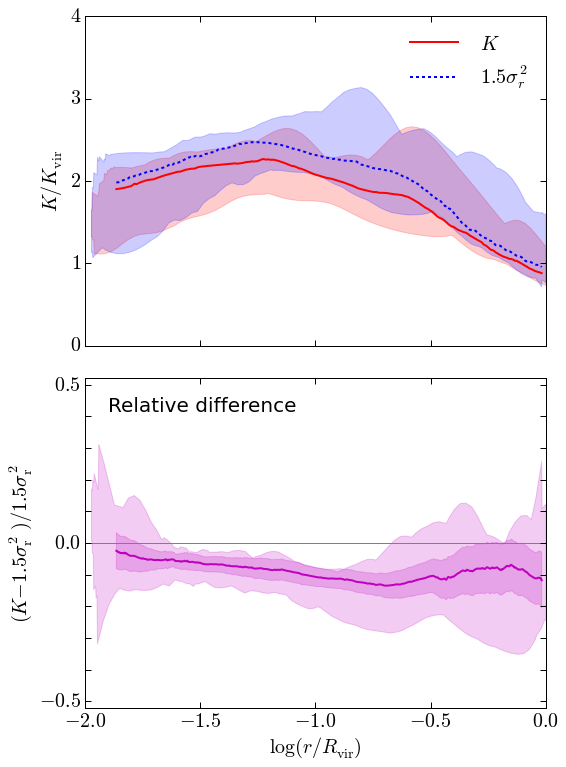

In [22]:
alpha_fill=0.2

fig=figure(figsize=figsize)
clf()

ax3=subplot(211)

fill_between(abscisse,K_min,K_max,color='r',alpha=alpha_fill)
plot(abscisse,K_med,color='r',lw=2,label=r'$K$')

fill_between(abscisse,Ksigma0_min,Ksigma0_max,color='b',alpha=alpha_fill)
plot(abscisse,Ksigma0_med,color='b',ls='--',dashes=(3,3),lw=2,label=r'$1.5 \sigma_r^2$')

ylabel(r'$K/K_{\rm vir}$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$
legend(fontsize=legendsize,frameon=False,loc='upper right',handlelength=3)

ax3.invert_yaxis()
yticknames=['$%i$'%int(item) for item in linspace(0,4,5)]
yticks(linspace(0,4,5),yticknames)

xticknames=['$%.1f$'%log10(item) for item in logspace(-2,1,7)]
xticks(log10(logspace(-2,1,7)),xticknames)

ylim(0,4)
xlim(rlim)

ax2=subplot(212, sharex=ax3)

axhline(0,color='gray')

fill_between(abscisse,DK0_min,DK0_max,color='m',alpha=alpha_fill)
fill_between(abscisse,DK0_med-DK0_rms,DK0_med+DK0_rms,color='m',alpha=alpha_fill)
plot(abscisse,DK0_med,lw=2,color='m')

xlabel(r'$\log(r/R_{\rm vir})$',fontsize=fontsize)
ylabel(r'$(K-1.5 \sigma_{\rm r}^2)/1.5\sigma_{\rm r}^2$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$

xticknames=['$%.1f$'%log10(item) for item in logspace(-2,0,5)]
xticks(log10(logspace(-2,0,5)),xticknames,visible=True)

yticknames=['$%.1f$'%log10(item) for item in logspace(-0.5,0.5,11)]
yticknames=['$-0.5$', ' ', ' ', ' ', ' ', '$0.0$', ' ', ' ', ' ', ' ','$0.5$']
yticks(log10(logspace(-0.5,0.5,11)),yticknames,visible=True)

ylim(-.52,.52)
xlim(rlim)

ax=gca()
ax.text(0.05,0.9,r'Relative difference',fontsize=fontsize,transform=ax.transAxes)

setp(ax3.get_xticklabels(), visible=False)